# SIMULATED DATASET 

In [149]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import torch
from crossevopred.src.model.dummy_model import DummyModel
from crossevopred.src.model.dummy_trainer import DummyTrainer
from crossevopred.utils.data_processing_utils import *
from crossevopred.src.data.dataset import ExpressionDataset
from crossevopred.src.data.encoder import *
import yaml
from crossevopred.src.eval.losses import PearsonCorrelationLoss


%load_ext autoreload
%autoreload 2

config_file = 'crossevopred/config/config.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
def window_array(arr, window_size):
    return np.array([np.mean(arr[i:i+window_size]) for i in range(0, len(arr)-window_size+1, window_size)])

def write_bed_file(sequences, scores, output_bed):
    with open(output_bed, "w") as f:
        for i in range(len(sequences)):
            sequence = sequences[i]
            score = scores[i]
            f.write("chr1\t{}\t{}\t{}\t{}\n".format(i, i+len(sequence), ','.join([str(x) for x in score]), sequence))
# Simulate N sequences of length L. Each A +4, C+3, G+2, T+0 . 
# The output is a bed file with chr1 x y fasta_sequence [score_pos1, score_pos2, ...]
# in the simulation I want to have sequences that are very A rich and sequences that are very T rich.
# but still have some C and G.
def simulate_sequences(N, L, window_size, output_bed):
    sequences = []
    for i in range(int(N/2)):
        sequence = np.random.choice(["A", "C", "G", "T"], L, p=[0.5, 0.25, 0.25, 0])
        sequences.append("".join(sequence))
    for i in range(int(N/2)):
        sequence = np.random.choice(["A", "C", "G", "T"], L, p=[0, 0.25, 0.25, 0.5])
        sequences.append("".join(sequence))
    sequences = np.array(sequences)
    # scores are 4 for A, 3 for C, 2 for G, 0 for T
    scores = np.array([[4 if c == "A" else 3 if c == "C" else 2 if c == "G" else 0 for c in sequence] for sequence in sequences])
    scores = np.array([window_array(score, window_size) for score in scores])
    
    # shuffle sequences and scores but keep them in the same order
    p = np.random.permutation(len(sequences))
    sequences = sequences[p]
    scores = scores[p]
    # write it in 3 different bed files (train, val, test)
    # proportions 80% train, 10% val, 10% test
    train_proportion = 0.8
    val_proportion = 0.1
    test_proportion = 0.1
    train_size = int(N * train_proportion)
    val_size = int(N * val_proportion)
    test_size = int(N * test_proportion)
    train_sequences = sequences[:train_size]
    val_sequences = sequences[train_size:train_size+val_size]
    test_sequences = sequences[train_size+val_size:]
    train_scores = scores[:train_size]
    val_scores = scores[train_size:train_size+val_size]
    test_scores = scores[train_size+val_size:]
    # write bed files
    write_bed_file(train_sequences, train_scores, output_bed + "_train.bed")
    write_bed_file(val_sequences, val_scores, output_bed + "_val.bed")
    write_bed_file(test_sequences, test_scores, output_bed + "_test.bed")

    return output_bed + "_train.bed", output_bed + "_val.bed", output_bed + "_test.bed"

# Create simulated data
training_file = "../simulated/simulated"
config_file = "../bin/crossevopred/config/test_config.yaml"
simulate_sequences(N = 40, L = 1000, window_size= 128, output_bed=training_file)

# Create simulated dataset
training_dataset = ExpressionDataset(training_file+ "_train.bed")
training_dataset_file = training_file+ "_test_dataset.pt"
torch.save(training_dataset, training_dataset_file)

# Create simulated dataset
test_dataset = ExpressionDataset(training_file+ "_test.bed")
test_dataset_file = training_file+ "_test_dataset.pt"
torch.save(test_dataset, test_dataset_file)

# Create simulated dataset
val_dataset = ExpressionDataset(training_file+ "_val.bed")
val_dataset_file = training_file+ "_val_dataset.pt"
torch.save(val_dataset, val_dataset_file)


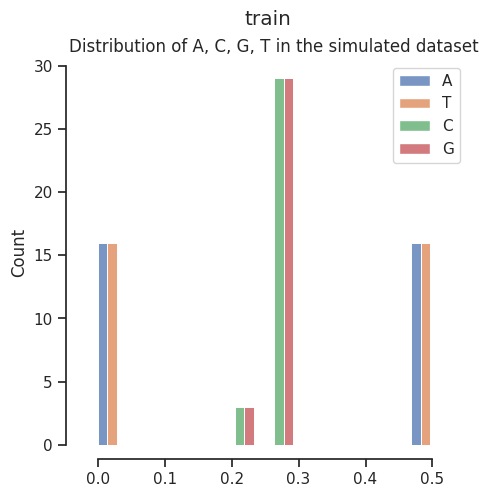

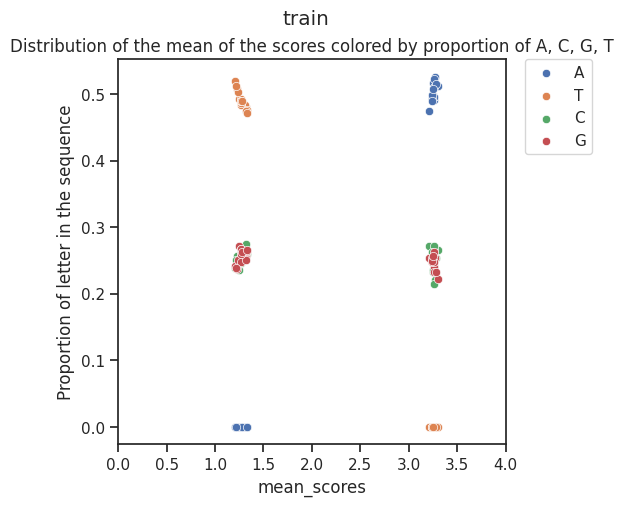

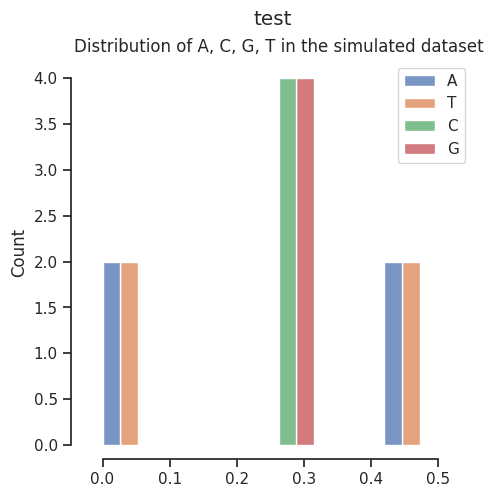

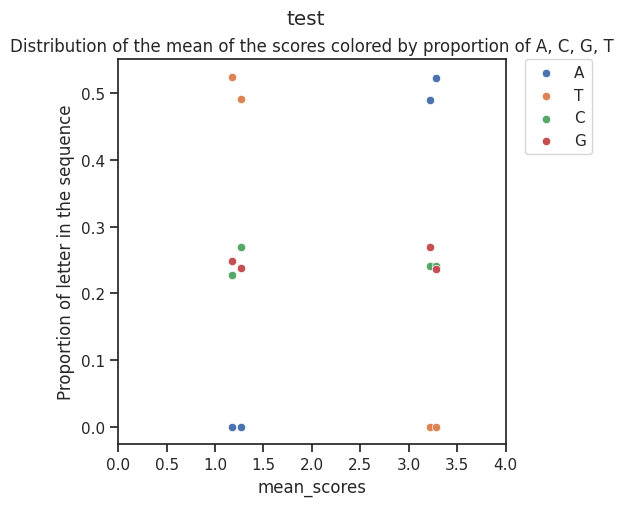

In [151]:
# Shut off warnings
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = [2, 2]

# Visualize the dataset distributions of the simulated data

suptitle = "Simulated data"
# calculate A, C, G, T proportions

def prep_df_input_file(file):
    df = pd.read_csv(file, sep="\t", header=None)
    df.columns = ["chr", "start", "end", "scores", "sequence"]
    df["A"] = df["sequence"].apply(lambda x: x.count("A")/len(x))
    df["C"] = df["sequence"].apply(lambda x: x.count("C")/len(x))
    df["G"] = df["sequence"].apply(lambda x: x.count("G")/len(x))
    df["T"] = df["sequence"].apply(lambda x: x.count("T")/len(x))
    df["mean_scores"] = df["scores"].apply(lambda x: np.mean([float(i) for i in x.split(",")]))
    return df

def plot_distribution(df, suptitle = "", title = "Distribution of A, C, G, T in the simulated dataset"):
    plot_1 = plt.figure(figsize=(5, 5))  # Adjust width and height as needed
    plot_1 = sns.histplot(df[["A",  "T", "C", "G"]], multiple = "dodge")
    # add log scale
    plt.title(title)
    sns.despine(offset=10, trim=True)
    plt.suptitle(suptitle)
    return plot_1

def plot_scatter_labels(df, suptitle = "", title = "Scatter plot"):
    plot_2 = plt.figure(figsize=(5, 5))  # Adjust width and height as needed
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="A", label="A")
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="T", label="T")
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="C", label="C")
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="G", label="G")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Proportion of letter in the sequence")
    # x axis start from 0 
    plt.xlim(0, 4)
    plt.title("Distribution of the mean of the scores colored by proportion of A, C, G, T")
    # subtitle
    plt.suptitle(suptitle)
    return plot_2

train_df = prep_df_input_file(training_file+ "_train.bed")
val_df = prep_df_input_file(training_file+ "_val.bed")
test_df = prep_df_input_file(training_file+ "_test.bed")

# train
plot1 = plot_distribution(train_df, "train")
plot2 = plot_scatter_labels(train_df, "train")
# test
plot1 = plot_distribution(test_df, "test")
plot2 = plot_scatter_labels(test_df, "test")

In [163]:
# retrain model 
import pandas as pd
import numpy as np
from Bio import SeqIO
import torch
from crossevopred.src.model.dummy_model import DummyModel
from crossevopred.src.model.dummy_trainer import DummyTrainer
from crossevopred.utils.data_processing_utils import *
from crossevopred.src.data.dataset import ExpressionDataset
from crossevopred.src.data.encoder import *

model   = DummyModel()
trainer = DummyTrainer(verbose=True)
trainining_datatset_loader = torch.load(training_dataset_file)
# Train the model
trainer.train(trainining_datatset_loader, config_file=config_file, model=model)


 -  Epoch 1/10
 -  Epoch avg loss: -0.21343011409044266
 -  Epoch 2/10
 -  Epoch avg loss: -0.6479210369288921
 -  Epoch 3/10
 -  Epoch avg loss: -0.7487815544009209
 -  Epoch 4/10
 -  Epoch avg loss: -0.7706368342041969
 -  Epoch 5/10
 -  Epoch avg loss: -0.8362705707550049
 -  Epoch 6/10
 -  Epoch avg loss: -0.8634105771780014
 -  Epoch 7/10
 -  Epoch avg loss: -0.888504683971405
 -  Epoch 8/10
 -  Epoch avg loss: -0.9218753278255463
 -  Epoch 9/10
 -  Epoch avg loss: -0.9399148970842361
 -  Epoch 10/10
 -  Epoch avg loss: -0.9468173384666443


In [164]:
# predict on my test set
test_dataset_loader = torch.load(test_dataset_file)
encoder = DNAEncoder()

In [165]:
test_dataset_loader.sequences[0].shape

torch.Size([4, 1000])

In [166]:
with torch.no_grad():
        for sequence, label in test_dataset_loader:
                decoded_sequence = encoder.decode_one_hot(sequence.numpy())
                # count the number of A, C, G, T in string
                print("A: ", decoded_sequence.count("A"),
                      "C: ", decoded_sequence.count("C"), 
                      "G: ", decoded_sequence.count("G"),
                      "T: ", decoded_sequence.count("T"))
                output = model(sequence)
                print("Real label: ", label)
                print("Predicted label: ", output)
                with open(config_file, "r") as c:
                  config = yaml.safe_load(c)  
                loss_function = globals()[config["loss_function"]]()
                print("Loss: ", loss_function(output.squeeze(), label.float()))
                print("--------------------")

A:  0 C:  227 G:  248 T:  525
Real label:  tensor([1.2500, 1.2266, 1.1484, 1.0938, 1.3281, 1.1875, 1.0234])
Predicted label:  tensor([ 139.0267,   41.1381, -111.7290,  -87.8685,  150.7221,   49.0781,
         -93.5360])
Loss:  tensor(-0.8873)
--------------------
A:  490 C:  241 G:  269 T:  0
Real label:  tensor([3.1641, 3.2969, 3.3594, 3.1875, 3.2422, 3.2031, 3.0859])
Predicted label:  tensor([ -18.6316,  107.0807,  131.5562,    0.1791,    8.4808,    3.9875,
        -112.4471])
Loss:  tensor(-0.9770)
--------------------
A:  0 C:  270 G:  238 T:  492
Real label:  tensor([1.3672, 1.3203, 1.1484, 1.1250, 1.2266, 1.3438, 1.3516])
Predicted label:  tensor([ 152.5486,   85.5587, -158.3816, -168.1214,   41.9591,  112.2128,
          50.7722])
Loss:  tensor(-0.9401)
--------------------
A:  523 C:  241 G:  236 T:  0
Real label:  tensor([3.3047, 3.3125, 3.3281, 3.2734, 3.2734, 3.2891, 3.2188])
Predicted label:  tensor([  81.3377,   78.0458,   96.9705,  -13.7440,    2.7315,   21.2438,
        

In [167]:
a = [3.3047, 3.3125, 3.3281, 3.2734, 3.2734, 3.2891, 3.2188]
b = [  81.3377,   78.0458,   96.9705,  -13.7440,    2.7315,   21.2438, -129.7567]

# calculate the pearson correlation
np.corrcoef(a, b)

array([[1.        , 0.98875062],
       [0.98875062, 1.        ]])